In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
from functools import reduce
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error
from math import sqrt

## Data ETL

In [10]:
# =======================
# Training Data (84 rows)
# =======================
train = pd.read_csv('data/ML_Train.csv')
test = pd.read_csv('data/ML_Test.csv')

XTr = train[['SP', 'P', 'FD', 'O', 'AC', 'MD', 'CW', 'N', 'FA']].to_numpy()
YTr = train[['Label']].to_numpy().flatten()
YTrProb = train[['Probability']].to_numpy().flatten()

# =======================
# Testing Data (800 rows)
# =======================
L = test.copy()
mask1 = (L['Probability'] >= 0.5)
mask0 = (L['Probability'] < 0.5)
L['Label'][mask1] = 1.0
L['Label'][mask0] = 0.0

XTe = test[['SP', 'P', 'FD', 'O', 'AC', 'MD', 'CW', 'N', 'FA']].to_numpy()
YTe = L[['Label']].to_numpy().flatten()
YTeProb = test[['Probability']].to_numpy().flatten()


# =======================
# Full Data (884 rows)
# =======================
frames = [train, L]
full = pd.concat(frames)

X = full[['SP', 'P', 'FD', 'O', 'AC', 'MD', 'CW', 'N', 'FA']].to_numpy()
Y = full[['Label']].to_numpy().flatten()
YProb = full[['Probability']].to_numpy().flatten()

## Classifiers
<br> 
### Gaussian Process Classifiers
#### Training Size: 84(Hand Labeled)

In [210]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

K = 1**2 * RBF(1)
gpc = GaussianProcessClassifier(kernel=K,n_restarts_optimizer=100).fit(XTr,YTr)

print("Fit Score: %3f" % gpc.score(XTr,YTr))
print("Log Marginal Likelihood: %.3f" % gpc.log_marginal_likelihood(gpc.kernel_.theta))
print("Accuracy: %3f" % accuracy_score(YTr, gpc.predict(XTr)))
print("TR|Log Loss: %3f" % log_loss(YTr, gpc.predict_proba(XTr)))
print("TR|RMS Error of Probablities: %3f" % sqrt(mean_squared_error(YTrProb, gpc.predict_proba(XTr)[:,1])))
print()
print("TE|Log Loss: %3f" % log_loss(YTe, gpc.predict_proba(XTe)))
print("TE|RMS Error of Probablities: %3f" % sqrt(mean_squared_error(YTeProb, gpc.predict_proba(XTe)[:,1])))

# Runs:                         1                 100                 1000
# ----------------------------------------------------------------------------------
# Fit Score:                    1.000000          0.880952            ~ 
# Log Marginal Likelihood:      -58.224           -39.495             ~ 
# Accuracy:                     1.000000          0.880952            ~  
# TR|Log Loss:                  0.692716          0.323553            ~ 
# TR|RMS Error of Probablities: 0.380603          0.197477            ~ 

# TE|Log Loss:                  0.693147          0.474037            ~
# TE|RMS Error of Probablities: 0.371212          0.265399            ~

Fit Score: 0.880952
Log Marginal Likelihood: -39.495
Accuracy: 0.880952
TR|Log Loss: 0.323553
TR|RMS Error of Probablities: 0.197477

TE|Log Loss: 0.474037
TE|RMS Error of Probablities: 0.265399


#### Training Size: 884(Full Dataset)

In [211]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

K = 1**2 * RBF(1)
gpc = GaussianProcessClassifier(kernel=K, n_restarts_optimizer=1000).fit(X,Y)

print("Fit Score: %3f" % gpc.score(X,Y))
print("Log Marginal Likelihood: %.3f" % gpc.log_marginal_likelihood(gpc.kernel_.theta))
print("Accuracy: %3f" % accuracy_score(Y, gpc.predict(X)))
print("Log Loss: %3f" % log_loss(Y, gpc.predict_proba(X)))
print("RMS Error of Probablities: %3f" % sqrt(mean_squared_error(YProb, gpc.predict_proba(X)[:,1])))

# Runs:                      1                 100                 1000
# ----------------------------------------------------------------------------
# Fit Score:                 1.000000          0.856635            ~                
# Log Marginal Likelihood:   -585.016          -326.251            ~
# Accuracy:                  1.000000          0.856635            ~ 
# Log Loss:                  0.693102          0.319140            ~  
# RMS Error of Probablities: 0.372156          0.211260            ~ 

Fit Score: 0.856635
Log Marginal Likelihood: -326.251
Accuracy: 0.856635
Log Loss: 0.319140
RMS Error of Probablities: 0.211260


#### Optimizor

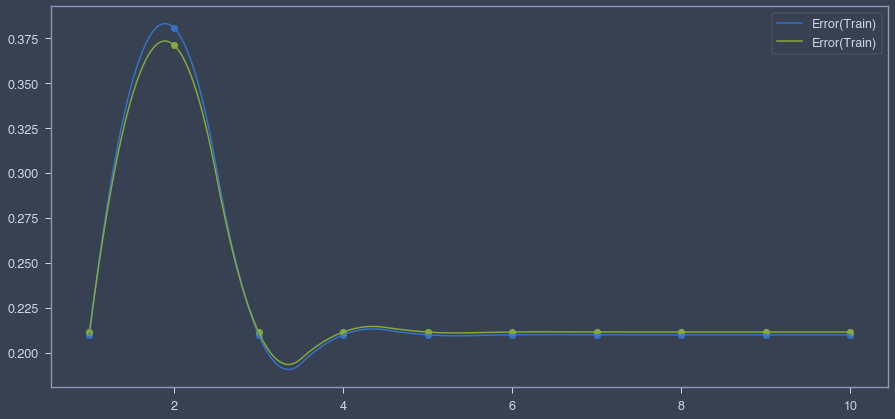

In [54]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from scipy.interpolate import interp1d

from jupyterthemes import jtplot
jtplot.style(theme='oceans16', context='notebook', ticks=True, grid=False)

def skynetGP(N):
    K = 1**2 * RBF(1)
    gpc = GaussianProcessClassifier(kernel=K, n_restarts_optimizer=N).fit(X,Y)
    errorTr = sqrt(mean_squared_error(YTrProb, gpc.predict_proba(XTr)[:,1]))
    errorTe = sqrt(mean_squared_error(YTeProb, gpc.predict_proba(XTe)[:,1]))
    return errorTr, errorTe

errorTr, errorTe, Ns = [], [], list(range(1,11))
for N in Ns:
    Tr,Te = skynetGP(N)
    errorTr.append(Tr)
    errorTe.append(Te)

# =================
# Error Plotting
# =================
Ns = np.array(Ns)
NsNEW = np.linspace(Ns.min(), Ns.max(),500)

f = interp1d(Ns, errorTr, kind='quadratic')
f1 = interp1d(Ns, errorTe, kind='quadratic')
errorTrNEW, errorTeNEW = f(NsNEW), f1(NsNEW)

plt.figure(figsize=[15, 7])
plt.plot(NsNEW,errorTrNEW, label="Error(Train)")
plt.plot(NsNEW,errorTeNEW, label="Error(Train)")
plt.scatter (Ns, errorTr)
plt.scatter (Ns, errorTe)
plt.legend()
plt.show()
    

### Gaussian Naive Bayes Classifier

In [55]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(XTr,YTr)

print("Fit Score: %3f" % nb.score(XTr,YTr))
print("Log Marginal Likelihood: ")
print("Accuracy: %3f" % accuracy_score(YTr, nb.predict(XTr)))
print("TR|Log Loss: %3f" % log_loss(YTr, nb.predict_proba(XTr)))
print("TR|RMS Error of Probablities: %3f" % sqrt(mean_squared_error(YTrProb, nb.predict_proba(XTr)[:,1])))
print()
print("TE|Log Loss: %3f" % log_loss(YTe, nb.predict_proba(XTe)))
print("TE|RMS Error of Probablities: %3f" % sqrt(mean_squared_error(YTeProb, nb.predict_proba(XTe)[:,1])))        

Fit Score: 0.833333
Log Marginal Likelihood: 
Accuracy: 0.833333
TR|Log Loss: 0.503909
TR|RMS Error of Probablities: 0.300893

TE|Log Loss: 1.574169
TE|RMS Error of Probablities: 0.390764


### Support Vector Classifiers

In [229]:
from sklearn import svm
svc = svm.SVC(probability=True, C=1)
svc.fit(XTr, YTr)

print("Fit Score: %3f" % svc.score(XTr,YTr))
print("Log Marginal Likelihood: ")
print("Accuracy: %3f" % accuracy_score(YTr, svc.predict(XTr)))
print("Log Loss: %3f" % log_loss(YTr, svc.predict_proba(XTr)))
print("RMS Error of Probablities: %3f" % sqrt(mean_squared_error(YTrProb, svc.predict_proba(XTr)[:,1])))

Fit Score: 0.880952
Log Marginal Likelihood: 
Accuracy: 0.880952
Log Loss: 0.310261
RMS Error of Probablities: 0.213975
